In [1]:
# 라이브러리 호출
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

In [2]:
# MAT 파일 불러오기
mat_path = r"../HW3_package/hw3_prob3.mat"
mat_data = scipy.io.loadmat(mat_path)

A = mat_data['A']
b = mat_data['b']
x_orig = mat_data['x_orig']

In [3]:
def normest_numpy(A):
    """
    NumPy를 이용하여 행렬 A의 2-노름을 추정하는 함수.
    """
    # SVD를 계산합니다. full_matrices=False로 설정하여 경제적 SVD를 수행합니다.
    U, s, V = scipy.sparse.linalg.svds(A)
    # 가장 큰 특이값 반환
    return s[0]

def Dh(u):
    rows, cols = u.shape
    d = np.zeros((rows, cols))
    d[:, 1:cols] = u[:, 1:cols] - u[:, 0:cols-1]
    d[:, 0] = u[:, 0] - u[:, cols-1]
    return d

def Dht(u):
    rows, cols = u.shape
    d = np.zeros((rows, cols))
    d[:, 0:cols-1] = u[:, 0:cols-1] - u[:, 1:cols]
    d[:, cols-1] = u[:, cols-1] - u[:, 0]
    return d

def Dv(u):
    rows, cols = u.shape
    d = np.zeros((rows, cols))
    d[1:rows, :] = u[1:rows, :] - u[0:rows-1, :]
    d[0, :] = u[0, :] - u[rows-1, :]
    return d

def Dvt(u):
    rows, cols = u.shape
    d = np.zeros((rows, cols))
    d[0:rows-1, :] = u[0:rows-1, :] - u[1:rows, :]
    d[rows-1, :] = u[rows-1, :] - u[0, :]
    return d

In [4]:
mu = 1
stopping_point = 2e-4

# # normest를 이용해 tau와 sigma 계산
norm_est = normest_numpy(A)
tau = 1 / norm_est**2
sigma = 1 / (tau * norm_est**2)

theta = 1/np.sqrt(1 + 2 * mu)

In [5]:
y1 = np.zeros(b.shape)
y2 = np.zeros((256,256))
y3 = np.zeros((256,256))
x = np.zeros((256,256))

for idx in range(10000):
    
    y2 = Dh(x)
    y3 = Dv(x)
    
    # update y
    y2 = np.sign(y2 + sigma * Dh(x)) * np.minimum(np.abs(y2 + sigma * Dh(x)), sigma)
    y3 = np.sign(y3 + sigma * Dv(x)) * np.minimum(np.abs(y3 + sigma * Dv(x)), sigma)
    
    x = x.reshape(65536, 1)
    y1 = ((y1 + sigma * A @ x) - (sigma * mu * b)) / (1 + sigma * mu)    
    
    # update x
    x_minus1 = x
    
    y2 = Dht(y2) 
    y3 = Dvt(y3)
    y2 = y2.reshape(65536, 1)
    y3 = y3.reshape(65536, 1)
    
    x = x - (tau * (A.T @ y1 + y2 + y3))
    x[x < 0] = 0
        

    x = x + theta * (x - x_minus1)

    x = x.reshape(256,256)
    y2 = y2.reshape(256,256)
    y3 = y3.reshape(256,256)
    x_minus1 = x_minus1.reshape(256,256)
    
    if (np.linalg.norm((x - x_minus1), 2) / np.linalg.norm(x, 2)) < stopping_point:
        break

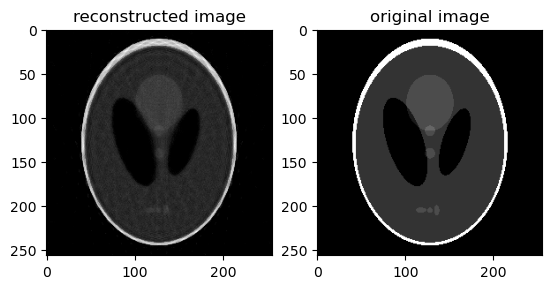

In [6]:
# original f 
x = x.reshape((256, 256))
plt.subplot(121)
plt.imshow(x.T, cmap = "gray")
plt.title( label = "reconstructed image")

 
x = x.reshape((256, 256))
plt.subplot(122)
plt.imshow(x_orig, cmap = "gray")
plt.title( label = "original image")

plt.show()